In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [45]:
data, labels = load_iris(return_X_y=True)
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)
X_train = train_data.astype(np.float32)
X_test = test_data.astype(np.float32)

In [46]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    for X_batch in dataset:
      # phase 1 - training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_data = generator(noise)
      X_fake_and_real = tf.concat([generated_data, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      # phase 2 - training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)

In [47]:
gans = []
generators = []
codings_size = 2
batch_size = 32
for i in range(3):
  generator = keras.models.Sequential([
    keras.layers.Dense(150, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(50, activation="selu"),
    keras.layers.Dense(25, activation="selu"),
    keras.layers.Dense(4, activation="sigmoid")
  ])

  discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[4]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
  ])

  gan = keras.models.Sequential([generator, discriminator])

  discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
  discriminator.trainable = False
  gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

  dataset = tf.data.Dataset.from_tensor_slices(X_train[train_labels==i]).shuffle(1000)
  dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

  train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

  gans.append(gan)
  generators.append(generator)

In [48]:
def plot(X, y):
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

  plt.figure(2, figsize=(8, 6))
  plt.clf()

  # Plot the training points
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
              edgecolor='k')

  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)

In [49]:
X = []
y = []
for i in range(3):
  noise = tf.random.normal(shape=[batch_size, codings_size])
  generated_data = generators[i](noise)
  generated_data_pca2d = PCA(2).fit_transform(generated_data)
  X.append(generated_data_pca2d)
  y.append([i] * len(generated_data_pca2d))

X = np.concatenate(X)
y = np.concatenate(y)

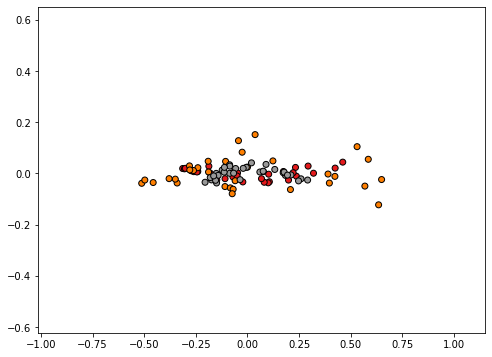

In [50]:
plot(X, y)